In [1]:
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

flights = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/flights.csv')

In [2]:
flights.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [3]:
flights['day'] = '01'
flights['year'] = flights['year'].astype(str)
flights['date'] = flights[['year', 'month', 'day']].apply(lambda x: '-'.join(x), axis=1)
flights = flights.set_index( pd.to_datetime( flights['date']) )
flights = flights.drop(['year', 'month', 'day',  'date'], axis=1)
flights.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


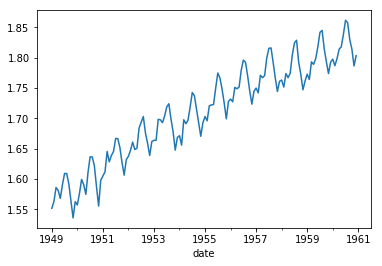

In [4]:
flights['passengers_log'] = np.log(flights['passengers'])
_ = np.log(flights['passengers_log']).plot()

### Discussion

- trend can be seen by decreasing correlations
- seasonal cycle can be seen by dips

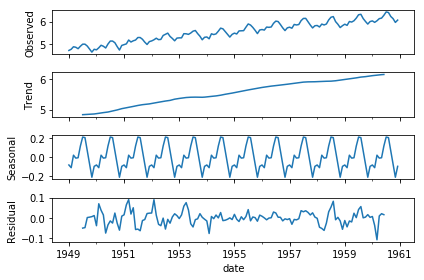

In [5]:
decomposition = sm.tsa.seasonal_decompose(flights['passengers_log'], model='additive')
fig = decomposition.plot()
plt.show()

### Estimating the trend component - Moving Average

In [6]:
flights['passengers_ma5'] = flights['passengers'].rolling(window=5).mean()
flights = flights[ ~ np.isnan(flights['passengers_ma5']) ]

In [7]:
flights.head()

,passengers,passengers_log,passengers_ma5
date,,,
1949-05-01,121,4.795791,122.4
1949-06-01,135,4.905275,127.0
1949-07-01,148,4.997212,133.0
1949-08-01,148,4.997212,136.2
1949-09-01,136,4.912655,137.6


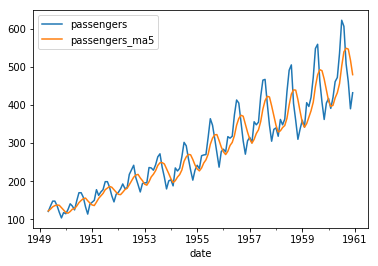

In [14]:
ax = flights['passengers'].plot(legend=True)
_ = flights['passengers_ma5'].plot(ax=ax, legend=True)